In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [2]:
data = pd.read_csv('data/credit_engineered_data.csv', index_col=0)
data.shape

(100000, 32)

In [3]:
data.head()

,ID,Customer_ID,Month,Occupation,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Delay_from_due_date,Credit_Mix,...,total_financial_obligations,total_credit_utilization,delayed_payment_impact,age_group,salary_deviation,banking_to_credit_ratio,annual_savings_estimate,credit_card_limit_utilization,debt_utilization_interaction,interest_bank_accounts_interaction
0,0x1602,CUS_0xd40,January,Scientist,1824.843333,3,4,3,3,unknown,...,857.061477,107.290478,9,lt30,-2426.523172,1.333333,21041.058523,71.870453,21725.785443,9
1,0x1603,CUS_0xd40,February,Scientist,1824.843333,3,4,3,-1,Good,...,857.061477,127.779840,-3,lt30,-2426.523172,1.333333,21041.058523,71.870453,25874.778746,9
2,0x1604,CUS_0xd40,March,Scientist,1824.843333,3,4,3,3,Good,...,857.061477,114.437408,9,30_40,-2426.523172,1.333333,21041.058523,128.432347,23173.002951,9
3,0x1605,CUS_0xd40,April,Scientist,1824.843333,3,4,3,5,Good,...,857.061477,125.511447,15,lt30,-2426.523172,1.333333,21041.058523,129.183413,25415.440557,9
4,0x1606,CUS_0xd40,May,Scientist,1824.843333,3,4,3,6,Good,...,857.061477,99.189388,18,lt30,-2426.523172,1.333333,21041.058523,71.870453,20085.355049,9


In [4]:
data.columns

Index(['ID', 'Customer_ID', 'Month', 'Occupation', 'Monthly_Inhand_Salary',
       'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate',
       'Delay_from_due_date', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Payment_Behaviour',
       'Annual_Income_cleaned', 'Credit_Score', 'imputed_age', 'imputed_ccl',
       'imputed_monthly_balance', 'total_emi_per_month_transform',
       'num_loan_transform', 'debt_to_income_ratio', 'loan_to_income_ratio',
       'total_financial_obligations', 'total_credit_utilization',
       'delayed_payment_impact', 'age_group', 'salary_deviation',
       'banking_to_credit_ratio', 'annual_savings_estimate',
       'credit_card_limit_utilization', 'debt_utilization_interaction',
       'interest_bank_accounts_interaction'],
      dtype='object')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0 to 99999
Data columns (total 32 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   ID                                  100000 non-null  object 
 1   Customer_ID                         100000 non-null  object 
 2   Month                               100000 non-null  object 
 3   Occupation                          100000 non-null  object 
 4   Monthly_Inhand_Salary               100000 non-null  float64
 5   Num_Bank_Accounts                   100000 non-null  int64  
 6   Num_Credit_Card                     100000 non-null  int64  
 7   Interest_Rate                       100000 non-null  int64  
 8   Delay_from_due_date                 100000 non-null  int64  
 9   Credit_Mix                          100000 non-null  object 
 10  Outstanding_Debt                    100000 non-null  float64
 11  Credit_Utilization_Ratio        

In [6]:
cat_cols = ['age_group', 'Payment_Behaviour', 'Month','Credit_Mix', 'Occupation']
num_cols = ['Monthly_Inhand_Salary',
       'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate',
       'Delay_from_due_date', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'imputed_age', 'imputed_ccl',
       'imputed_monthly_balance', 'total_emi_per_month_transform',
       'num_loan_transform', 'debt_to_income_ratio', 'loan_to_income_ratio',
       'total_financial_obligations', 'total_credit_utilization',
       'delayed_payment_impact', 'salary_deviation',
       'banking_to_credit_ratio', 'annual_savings_estimate',
       'credit_card_limit_utilization', 'debt_utilization_interaction',
       'interest_bank_accounts_interaction']
target_col = "Credit_Score"

In [7]:
data.head()

,ID,Customer_ID,Month,Occupation,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Delay_from_due_date,Credit_Mix,...,total_financial_obligations,total_credit_utilization,delayed_payment_impact,age_group,salary_deviation,banking_to_credit_ratio,annual_savings_estimate,credit_card_limit_utilization,debt_utilization_interaction,interest_bank_accounts_interaction
0,0x1602,CUS_0xd40,January,Scientist,1824.843333,3,4,3,3,unknown,...,857.061477,107.290478,9,lt30,-2426.523172,1.333333,21041.058523,71.870453,21725.785443,9
1,0x1603,CUS_0xd40,February,Scientist,1824.843333,3,4,3,-1,Good,...,857.061477,127.779840,-3,lt30,-2426.523172,1.333333,21041.058523,71.870453,25874.778746,9
2,0x1604,CUS_0xd40,March,Scientist,1824.843333,3,4,3,3,Good,...,857.061477,114.437408,9,30_40,-2426.523172,1.333333,21041.058523,128.432347,23173.002951,9
3,0x1605,CUS_0xd40,April,Scientist,1824.843333,3,4,3,5,Good,...,857.061477,125.511447,15,lt30,-2426.523172,1.333333,21041.058523,129.183413,25415.440557,9
4,0x1606,CUS_0xd40,May,Scientist,1824.843333,3,4,3,6,Good,...,857.061477,99.189388,18,lt30,-2426.523172,1.333333,21041.058523,71.870453,20085.355049,9


In [8]:
data.Month.unique()

array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August'], dtype=object)

In [9]:
data[target_col].value_counts()

Credit_Score
Standard    53174
Poor        28998
Good        17828
Name: count, dtype: int64

In [10]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [11]:
data.isna().sum()

ID                                       0
Customer_ID                              0
Month                                    0
Occupation                               0
Monthly_Inhand_Salary                    0
Num_Bank_Accounts                        0
Num_Credit_Card                          0
Interest_Rate                            0
Delay_from_due_date                      0
Credit_Mix                               0
Outstanding_Debt                         0
Credit_Utilization_Ratio                 0
Payment_Behaviour                        0
Annual_Income_cleaned                    0
Credit_Score                             0
imputed_age                              0
imputed_ccl                              0
imputed_monthly_balance                  0
total_emi_per_month_transform            0
num_loan_transform                       0
debt_to_income_ratio                     0
loan_to_income_ratio                     0
total_financial_obligations              0
total_credi

In [12]:
data.fillna(0, inplace=True)

In [13]:
data.Month.value_counts()

Month
January     12500
February    12500
March       12500
April       12500
May         12500
June        12500
July        12500
August      12500
Name: count, dtype: int64

In [14]:
data[data.Month=="August"].shape

(12500, 32)

In [15]:
hold_out = data[data.Month=="August"]

In [16]:
hold_out.Credit_Score.value_counts()

Credit_Score
Standard    6485
Poor        3602
Good        2413
Name: count, dtype: int64

In [17]:
train, test = train_test_split(data[data.Month!="August"], train_size=.8, stratify=data[data.Month!="August"][target_col])

In [18]:
train.shape, test.shape

((70000, 32), (17500, 32))

In [19]:
train[target_col].value_counts(), test[target_col].value_counts()

(Credit_Score
 Standard    37351
 Poor        20317
 Good        12332
 Name: count, dtype: int64,
 Credit_Score
 Standard    9338
 Poor        5079
 Good        3083
 Name: count, dtype: int64)

In [20]:
train.head()

,ID,Customer_ID,Month,Occupation,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Delay_from_due_date,Credit_Mix,...,total_financial_obligations,total_credit_utilization,delayed_payment_impact,age_group,salary_deviation,banking_to_credit_ratio,annual_savings_estimate,credit_card_limit_utilization,debt_utilization_interaction,interest_bank_accounts_interaction
12990,0x621c,CUS_0x67a4,July,Mechanic,1770.479167,6,5,33,21,Standard,...,2162.905322,119.226699,693,30_40,-2393.328048,0.833333,19082.844678,289.936986,50469.615592,198
20342,0x8d30,CUS_0x24ef,July,Writer,1733.225000,6,8,20,28,Bad,...,1889.938039,229.402027,560,40_50,-2508.511231,1.333333,18908.761961,448.525672,52603.892047,120
45654,0x12180,CUS_0x94cf,July,Entrepreneur,1237.526667,8,4,14,18,unknown,...,1530.106888,134.683941,252,30_40,-3003.020674,0.500000,13320.213112,244.438825,50452.941094,112
41837,0x10b23,CUS_0x39bd,June,Mechanic,6900.330000,9,8,17,42,Bad,...,3466.081033,200.787303,714,30_40,2736.522785,0.888889,79337.878967,142.763147,85170.962322,153
64988,0x192ca,CUS_0xb9bd,May,Entrepreneur,2673.771667,11,4,18,21,Standard,...,155.284766,95.398395,378,40_50,-1566.775674,0.363636,31929.975234,12.865361,2506.831321,198


In [21]:
X_train = train[cat_cols+num_cols]
y_train = train[target_col]

X_test = test[cat_cols+num_cols]
y_test = test[target_col]

In [22]:
X_train.shape, X_test.shape

((70000, 28), (17500, 28))

In [23]:
X_train.head()

,age_group,Payment_Behaviour,Month,Credit_Mix,Occupation,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Delay_from_due_date,...,loan_to_income_ratio,total_financial_obligations,total_credit_utilization,delayed_payment_impact,salary_deviation,banking_to_credit_ratio,annual_savings_estimate,credit_card_limit_utilization,debt_utilization_interaction,interest_bank_accounts_interaction
12990,30_40,Low_spent_Small_value_payments,July,Standard,Mechanic,1770.479167,6,5,33,21,...,0.002182,2162.905322,119.226699,693,-2393.328048,0.833333,19082.844678,289.936986,50469.615592,198
20342,40_50,Low_spent_Medium_value_payments,July,Bad,Writer,1733.225000,6,8,20,28,...,0.002667,1889.938039,229.402027,560,-2508.511231,1.333333,18908.761961,448.525672,52603.892047,120
45654,30_40,Low_spent_Small_value_payments,July,unknown,Entrepreneur,1237.526667,8,4,14,18,...,0.002134,1530.106888,134.683941,252,-3003.020674,0.500000,13320.213112,244.438825,50452.941094,112
41837,30_40,High_spent_Large_value_payments,June,Bad,Mechanic,6900.330000,9,8,17,42,...,0.000877,3466.081033,200.787303,714,2736.522785,0.888889,79337.878967,142.763147,85170.962322,153
64988,40_50,unknown,May,Standard,Entrepreneur,2673.771667,11,4,18,21,...,0.001564,155.284766,95.398395,378,-1566.775674,0.363636,31929.975234,12.865361,2506.831321,198


In [24]:
data[data.isna().any(axis=1)]

,ID,Customer_ID,Month,Occupation,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Delay_from_due_date,Credit_Mix,...,total_financial_obligations,total_credit_utilization,delayed_payment_impact,age_group,salary_deviation,banking_to_credit_ratio,annual_savings_estimate,credit_card_limit_utilization,debt_utilization_interaction,interest_bank_accounts_interaction


## Classification

### Baseline

In [25]:
def evaluate_model(y_true, y_pred_, probs):    
    print(classification_report(y_true=y_true, y_pred=y_pred_))
    print('ROC-AUC : ', roc_auc_score(y_true=y_true, y_score=probs, multi_class='ovo'))

In [26]:
y_encoder = LabelEncoder()
y_encoder.fit(y_train)

LabelEncoder()

In [27]:
y_encoder.classes_

array(['Good', 'Poor', 'Standard'], dtype=object)

In [28]:
y_encoded_train = y_encoder.transform(y_train)
y_encoded_test = y_encoder.transform(y_test)

In [29]:
baseline_model = LogisticRegression()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(), cat_cols),
        ('num', StandardScaler(), num_cols)
    ]
)

baseline_pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", baseline_model)]
)

baseline_pipe.fit(X_train, y_encoded_train)

train_preds = baseline_pipe.predict(X_train)
train_probs = baseline_pipe.predict_proba(X_train)
print('Training: ')
evaluate_model(y_encoded_train, train_preds, train_probs)

val_preds = baseline_pipe.predict(X_test) 
val_probs = baseline_pipe.predict_proba(X_test)
print('Validation: ')
evaluate_model(y_encoded_test, val_preds, val_probs)
print()

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training: 
              precision    recall  f1-score   support

           0       0.57      0.42      0.49     12332
           1       0.65      0.49      0.56     20317
           2       0.64      0.78      0.70     37351

    accuracy                           0.63     70000
   macro avg       0.62      0.56      0.58     70000
weighted avg       0.63      0.63      0.62     70000

ROC-AUC :  0.8035730668605311
Validation: 
              precision    recall  f1-score   support

           0       0.57      0.42      0.48      3083
           1       0.65      0.50      0.56      5079
           2       0.64      0.78      0.70      9338

    accuracy                           0.63     17500
   macro avg       0.62      0.56      0.58     17500
weighted avg       0.63      0.63      0.62     17500

ROC-AUC :  0.8045744710475032



### Feature Selection

In [30]:
pd.get_dummies(X_train)

,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Delay_from_due_date,Outstanding_Debt,Credit_Utilization_Ratio,imputed_age,imputed_ccl,imputed_monthly_balance,...,Occupation_Entrepreneur,Occupation_Journalist,Occupation_Lawyer,Occupation_Manager,Occupation_Mechanic,Occupation_Media_Manager,Occupation_Musician,Occupation_Scientist,Occupation_Teacher,Occupation_Writer
12990,1770.479167,6,5,33,21,2116.54,23.845340,31.0,7.30,288.245313,...,False,False,False,False,True,False,False,False,False,False
20342,1733.225000,6,8,20,28,1834.47,28.675253,44.0,4.09,232.118052,...,False,False,False,False,False,False,False,False,False,True
45654,1237.526667,8,4,14,18,1498.41,33.670985,37.0,6.13,300.055448,...,True,False,False,False,False,False,False,False,False,False
41837,6900.330000,9,8,17,42,3393.48,25.098413,35.0,23.77,411.978488,...,False,False,False,False,True,False,False,False,False,False
64988,2673.771667,11,4,18,21,105.11,23.849599,42.0,8.17,186.641633,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13968,1155.240833,8,5,5,18,1453.95,28.816231,23.0,18.37,229.083423,...,True,False,False,False,False,False,False,False,False,False
70201,2388.722500,5,4,12,11,180.68,37.352166,36.0,7.57,422.570767,...,False,False,False,False,False,False,False,False,False,True
35852,997.918333,7,7,14,18,789.89,35.342269,18.0,10.36,300.923797,...,False,False,False,False,False,False,False,False,False,False
55019,5790.620000,3,3,5,17,1116.18,24.170825,43.0,9.87,398.121630,...,False,False,False,False,False,False,False,False,False,True


In [31]:
def feature_selection(X, y, num_features=10):
    X = pd.get_dummies(X, drop_first=True)
    le = LabelEncoder()
    y = le.fit_transform(y)
    target_column = "Credit_Score"

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    selected_features = {}

    # 1. Univariate Selection (Chi-Squared)
    chi2_selector = SelectKBest(chi2, k=num_features)
    chi2_selector.fit(X_scaled, y)
    chi2_features = X.columns[chi2_selector.get_support()].tolist()
    selected_features['Chi2'] = chi2_features

    # 2. Mutual Information
    mi_selector = SelectKBest(mutual_info_classif, k=num_features)
    mi_selector.fit(X, y)
    mi_features = X.columns[mi_selector.get_support()].tolist()
    selected_features['Mutual_Info'] = mi_features

    # 3. Feature Importance from Random Forest
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X, y)
    feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
    rf_features = feature_importances.nlargest(num_features).index.tolist()
    selected_features['Random_Forest'] = rf_features

    # 4. Correlation-Based Selection
    correlation = pd.concat([X, pd.Series(y, name=target_column)], axis=1).corr()
    correlation_target = correlation[target_column].drop(target_column).abs()
    corr_features = correlation_target.nlargest(num_features).index.tolist()
    selected_features['Correlation'] = corr_features

    selected_features['All'] = list(X.columns)

    return selected_features

In [32]:
selected = feature_selection(X_train, y_train, num_features=10)

In [33]:
for method, features in selected.items():
    print(f"{method} Selected Features:")
    print(features)
    print()

Chi2 Selected Features:
['Interest_Rate', 'Delay_from_due_date', 'Outstanding_Debt', 'debt_to_income_ratio', 'total_financial_obligations', 'debt_utilization_interaction', 'interest_bank_accounts_interaction', 'age_group_gt50', 'Credit_Mix_Good', 'Credit_Mix_Standard']

Mutual_Info Selected Features:
['Monthly_Inhand_Salary', 'Outstanding_Debt', 'total_emi_per_month_transform', 'debt_to_income_ratio', 'loan_to_income_ratio', 'total_financial_obligations', 'salary_deviation', 'annual_savings_estimate', 'credit_card_limit_utilization', 'interest_bank_accounts_interaction']

Random_Forest Selected Features:
['total_financial_obligations', 'Outstanding_Debt', 'delayed_payment_impact', 'debt_to_income_ratio', 'interest_bank_accounts_interaction', 'debt_utilization_interaction', 'Interest_Rate', 'total_credit_utilization', 'imputed_ccl', 'Delay_from_due_date']

Correlation Selected Features:
['num_loan_transform', 'Payment_Behaviour_High_spent_Small_value_payments', 'Occupation_Journalist', 

### Model Selection

In [34]:
models = [LogisticRegression(), XGBClassifier(), RandomForestClassifier()] 

In [36]:
for model in models:
    for selected_feature in selected:
        print(f"{selected_feature}")
        print(model)
        X_train_scaled = pd.get_dummies(X_train, drop_first=True)
        X_test_scaled = pd.get_dummies(X_test, drop_first=True)
        le = LabelEncoder()
        y_train_scaled = le.fit_transform(y_train)
        y_test_scaled = le.fit_transform(y_test)
        target_column = "Credit_Score"
    
        scaler = MinMaxScaler()
        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_scaled), columns=X_train_scaled.columns)
        X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test_scaled), columns=X_test_scaled.columns)
    
        X_train_scaled = X_train_scaled[selected[selected_feature]]
        X_test_scaled = X_test_scaled[selected[selected_feature]]
        
        model.fit(X_train_scaled, y_encoded_train)
    
        train_preds = model.predict(X_train_scaled)
        train_probs = model.predict_proba(X_train_scaled)
        print('Training: ')
        evaluate_model(y_train_scaled, train_preds, train_probs)
      
        val_preds = model.predict(X_test_scaled) 
        val_probs = model.predict_proba(X_test_scaled)
        print('Validation: ')
        evaluate_model(y_test_scaled, val_preds, val_probs)
        print() 

Chi2
LogisticRegression()
Training: 
              precision    recall  f1-score   support

           0       0.51      0.62      0.56     12332
           1       0.59      0.45      0.51     20317
           2       0.65      0.70      0.67     37351

    accuracy                           0.61     70000
   macro avg       0.59      0.59      0.58     70000
weighted avg       0.61      0.61      0.61     70000

ROC-AUC :  0.7996078447291239
Validation: 
              precision    recall  f1-score   support

           0       0.52      0.62      0.57      3083
           1       0.60      0.46      0.52      5079
           2       0.66      0.70      0.68      9338

    accuracy                           0.62     17500
   macro avg       0.59      0.59      0.59     17500
weighted avg       0.62      0.62      0.61     17500

ROC-AUC :  0.8082843235408118

Mutual_Info
LogisticRegression()
Training: 
              precision    recall  f1-score   support

           0       0.45     

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training: 
              precision    recall  f1-score   support

           0       0.54      0.56      0.55     12332
           1       0.63      0.51      0.56     20317
           2       0.67      0.73      0.70     37351

    accuracy                           0.64     70000
   macro avg       0.61      0.60      0.60     70000
weighted avg       0.64      0.64      0.63     70000

ROC-AUC :  0.8184221407436242
Validation: 
              precision    recall  f1-score   support

           0       0.52      0.73      0.60      3083
           1       0.65      0.45      0.53      5079
           2       0.69      0.71      0.70      9338

    accuracy                           0.64     17500
   macro avg       0.62      0.63      0.61     17500
weighted avg       0.65      0.64      0.64     17500

ROC-AUC :  0.8268611785190383

Chi2
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_by

### Hyper paraeter tuning

In [39]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

#### XGBoost

In [57]:
space={
    'max_depth': hp.quniform("max_depth", 4, 10, 1),
    'tree_method': 'gpu_hist',
    'gamma': hp.uniform ('gamma', 1,9),
    'reg_alpha': hp.quniform('reg_alpha', 0, 1, .001),
    'subsample': hp.uniform('subsample', 0.6, 0.9),
    'reg_lambda': hp.quniform('reg_lambda', 0, 100, 1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
    'learning_rate': hp.uniform('learning_rate', .001, 0.5),
    'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
    'n_estimators': hp.uniform ('n_estimators', 10,180),
    'seed': 0
}

In [60]:
def objective(space):
    clf=XGBClassifier(
                    n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']), objective='multi:softmax',
                    colsample_bytree=int(space['colsample_bytree']), early_stopping_rounds=10)
    
    X_train_scaled = pd.get_dummies(X_train, drop_first=True)
    X_test_scaled = pd.get_dummies(X_test, drop_first=True)
    le = LabelEncoder()
    y_train_scaled = le.fit_transform(y_train)
    y_test_scaled = le.fit_transform(y_test)

    scaler = MinMaxScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_scaled), columns=X_train_scaled.columns)
    X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test_scaled), columns=X_test_scaled.columns)

    X_train_scaled = X_train_scaled[selected[selected_feature]]
    X_test_scaled = X_test_scaled[selected[selected_feature]]

    evaluation = [(X_train_scaled, y_train_scaled), (X_test_scaled, y_test_scaled)]
    
    clf.fit(X_train_scaled, y_train_scaled,
            eval_set=evaluation,verbose=False)
    
    pred = clf.predict(X_test_scaled)
    pred_prob = clf.predict_proba(X_test_scaled)
    evaluate_model(y_test_scaled, pred, pred_prob)
    return {'loss': -precision_score(y_encoded_test, pred, average="weighted"), 'status': STATUS_OK }

In [61]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 1000,
                        trials = trials)

              precision    recall  f1-score   support                                                                                                                  

           0       0.48      0.23      0.31      3083
           1       0.56      0.41      0.47      5079
           2       0.59      0.77      0.67      9338

    accuracy                           0.57     17500
   macro avg       0.54      0.47      0.48     17500
weighted avg       0.56      0.57      0.55     17500

ROC-AUC :                                                                                                                                                              
0.7566397627600429                                                                                                                                                     
              precision    recall  f1-score   support                                                                                                                  



/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

              precision    recall  f1-score   support                                                                                                                  

           0       0.49      0.23      0.32      3083
           1       0.55      0.41      0.47      5079
           2       0.59      0.77      0.67      9338

    accuracy                           0.57     17500
   macro avg       0.54      0.47      0.49     17500
weighted avg       0.56      0.57      0.55     17500

ROC-AUC :                                                                                                                                                              
0.7567568904721725                                                                                                                                                     
              precision    recall  f1-score   support                                                                                                                  



/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

              precision    recall  f1-score   support                                                                                                                  

           0       0.46      0.49      0.48      3083
           1       0.56      0.41      0.47      5079
           2       0.63      0.71      0.67      9338

    accuracy                           0.58     17500
   macro avg       0.55      0.54      0.54     17500
weighted avg       0.58      0.58      0.58     17500

ROC-AUC :                                                                                                                                                              
0.7584998660535686                                                                                                                                                     
              precision    recall  f1-score   support                                                                                                                  



/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

              precision    recall  f1-score   support                                                                                                                  

           0       0.46      0.47      0.46      3083
           1       0.55      0.41      0.47      5079
           2       0.63      0.71      0.67      9338

    accuracy                           0.58     17500
   macro avg       0.55      0.53      0.54     17500
weighted avg       0.58      0.58      0.58     17500

ROC-AUC :                                                                                                                                                              
0.75787123044984                                                                                                                                                       
              precision    recall  f1-score   support                                                                                                                  



/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

              precision    recall  f1-score   support                                                                                                                  

           0       0.46      0.49      0.47      3083
           1       0.55      0.41      0.47      5079
           2       0.63      0.71      0.67      9338

    accuracy                           0.58     17500
   macro avg       0.55      0.54      0.54     17500
weighted avg       0.58      0.58      0.58     17500

ROC-AUC :                                                                                                                                                              
0.7584723156543408                                                                                                                                                     
              precision    recall  f1-score   support                                                                                                                  



/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

              precision    recall  f1-score   support                                                                                                                  

           0       0.54      0.07      0.12      3083
           1       0.56      0.43      0.48      5079
           2       0.57      0.81      0.67      9338

    accuracy                           0.57     17500
   macro avg       0.55      0.43      0.42     17500
weighted avg       0.56      0.57      0.52     17500

ROC-AUC :                                                                                                                                                              
0.7501216628506665                                                                                                                                                     
              precision    recall  f1-score   support                                                                                                                  



/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

              precision    recall  f1-score   support                                                                                                                  

           0       0.48      0.25      0.33      3083
           1       0.56      0.41      0.47      5079
           2       0.59      0.77      0.67      9338

    accuracy                           0.57     17500
   macro avg       0.54      0.48      0.49     17500
weighted avg       0.56      0.57      0.55     17500

ROC-AUC :                                                                                                                                                              
0.7568347958106024                                                                                                                                                     
              precision    recall  f1-score   support                                                                                                                  



/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

              precision    recall  f1-score   support                                                                                                                  

           0       0.46      0.49      0.47      3083
           1       0.55      0.41      0.47      5079
           2       0.64      0.71      0.67      9338

    accuracy                           0.58     17500
   macro avg       0.55      0.54      0.54     17500
weighted avg       0.58      0.58      0.58     17500

ROC-AUC :                                                                                                                                                              
0.7584541864381628                                                                                                                                                     
              precision    recall  f1-score   support                                                                                                                  



/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

              precision    recall  f1-score   support                                                                                                                  

           0       0.46      0.49      0.47      3083
           1       0.55      0.41      0.47      5079
           2       0.63      0.71      0.67      9338

    accuracy                           0.58     17500
   macro avg       0.55      0.54      0.54     17500
weighted avg       0.58      0.58      0.58     17500

ROC-AUC :                                                                                                                                                              
0.7568090921461735                                                                                                                                                     
              precision    recall  f1-score   support                                                                                                                  



/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

              precision    recall  f1-score   support                                                                                                                  

           0       0.54      0.07      0.12      3083
           1       0.56      0.42      0.48      5079
           2       0.57      0.81      0.67      9338

    accuracy                           0.57     17500
   macro avg       0.55      0.43      0.42     17500
weighted avg       0.56      0.57      0.52     17500

ROC-AUC :                                                                                                                                                              
0.7502345626356849                                                                                                                                                     
              precision    recall  f1-score   support                                                                                                                  



/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

              precision    recall  f1-score   support                                                                                                                  

           0       0.46      0.47      0.46      3083
           1       0.55      0.41      0.47      5079
           2       0.63      0.71      0.67      9338

    accuracy                           0.58     17500
   macro avg       0.55      0.53      0.54     17500
weighted avg       0.58      0.58      0.58     17500

ROC-AUC :                                                                                                                                                              
0.7579632173655174                                                                                                                                                     
              precision    recall  f1-score   support                                                                                                                  



/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

              precision    recall  f1-score   support                                                                                                                  

           0       0.00      0.00      0.00      3083
           1       0.57      0.34      0.43      5079
           2       0.56      0.86      0.68      9338

    accuracy                           0.56     17500
   macro avg       0.38      0.40      0.37     17500
weighted avg       0.46      0.56      0.49     17500

ROC-AUC :                                                                                                                                                              
0.7404023295568766                                                                                                                                                     
 16%|███████████████▎                                                                             | 164/1000 [01:34<06:17,  2.21trial/s, best loss: -0.580526331922826]

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

              precision    recall  f1-score   support                                                                                                                  

           0       0.46      0.49      0.47      3083
           1       0.56      0.41      0.47      5079
           2       0.63      0.71      0.67      9338

    accuracy                           0.58     17500
   macro avg       0.55      0.54      0.54     17500
weighted avg       0.58      0.58      0.58     17500

ROC-AUC :                                                                                                                                                              
0.7584536057955522                                                                                                                                                     
              precision    recall  f1-score   support                                                                                                                  



/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

              precision    recall  f1-score   support                                                                                                                  

           0       0.46      0.49      0.47      3083
           1       0.55      0.41      0.47      5079
           2       0.64      0.71      0.67      9338

    accuracy                           0.58     17500
   macro avg       0.55      0.54      0.54     17500
weighted avg       0.58      0.58      0.58     17500

ROC-AUC :                                                                                                                                                              
0.7587063992218014                                                                                                                                                     
              precision    recall  f1-score   support                                                                                                                  



/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

              precision    recall  f1-score   support                                                                                                                  

           0       0.46      0.47      0.46      3083
           1       0.55      0.41      0.47      5079
           2       0.63      0.71      0.67      9338

    accuracy                           0.58     17500
   macro avg       0.55      0.53      0.53     17500
weighted avg       0.58      0.58      0.58     17500

ROC-AUC :                                                                                                                                                              
0.7570006000458774                                                                                                                                                     
              precision    recall  f1-score   support                                                                                                                  



/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

              precision    recall  f1-score   support                                                                                                                  

           0       0.46      0.47      0.46      3083
           1       0.55      0.41      0.47      5079
           2       0.63      0.71      0.67      9338

    accuracy                           0.58     17500
   macro avg       0.55      0.53      0.54     17500
weighted avg       0.58      0.58      0.58     17500

ROC-AUC :                                                                                                                                                              
0.7575937961088054                                                                                                                                                     
              precision    recall  f1-score   support                                                                                                                  



/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

              precision    recall  f1-score   support                                                                                                                  

           0       0.46      0.49      0.47      3083
           1       0.55      0.41      0.47      5079
           2       0.63      0.71      0.67      9338

    accuracy                           0.58     17500
   macro avg       0.55      0.54      0.54     17500
weighted avg       0.58      0.58      0.58     17500

ROC-AUC :                                                                                                                                                              
0.7585490660883627                                                                                                                                                     
              precision    recall  f1-score   support                                                                                                                  



/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

              precision    recall  f1-score   support                                                                                                                  

           0       0.46      0.49      0.47      3083
           1       0.55      0.41      0.47      5079
           2       0.64      0.70      0.67      9338

    accuracy                           0.58     17500
   macro avg       0.55      0.54      0.54     17500
weighted avg       0.58      0.58      0.58     17500

ROC-AUC :                                                                                                                                                              
0.758486777706103                                                                                                                                                      
              precision    recall  f1-score   support                                                                                                                  



/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

              precision    recall  f1-score   support                                                                                                                  

           0       0.46      0.47      0.46      3083
           1       0.55      0.41      0.47      5079
           2       0.63      0.71      0.67      9338

    accuracy                           0.58     17500
   macro avg       0.55      0.53      0.54     17500
weighted avg       0.58      0.58      0.58     17500

ROC-AUC :                                                                                                                                                              
0.7569263306026865                                                                                                                                                     
              precision    recall  f1-score   support                                                                                                                  



/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

              precision    recall  f1-score   support                                                                                                                  

           0       0.46      0.47      0.46      3083
           1       0.55      0.41      0.47      5079
           2       0.63      0.71      0.67      9338

    accuracy                           0.58     17500
   macro avg       0.55      0.53      0.54     17500
weighted avg       0.58      0.58      0.58     17500

ROC-AUC :                                                                                                                                                              
0.757195043196062                                                                                                                                                      
              precision    recall  f1-score   support                                                                                                                  



/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

              precision    recall  f1-score   support                                                                                                                  

           0       0.46      0.49      0.47      3083
           1       0.55      0.41      0.47      5079
           2       0.63      0.71      0.67      9338

    accuracy                           0.58     17500
   macro avg       0.55      0.54      0.54     17500
weighted avg       0.58      0.58      0.58     17500

ROC-AUC :                                                                                                                                                              
0.7570857305633893                                                                                                                                                     
              precision    recall  f1-score   support                                                                                                                  



/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

              precision    recall  f1-score   support                                                                                                                  

           0       0.45      0.48      0.47      3083
           1       0.55      0.41      0.47      5079
           2       0.63      0.71      0.67      9338

    accuracy                           0.58     17500
   macro avg       0.55      0.54      0.54     17500
weighted avg       0.58      0.58      0.58     17500

ROC-AUC :                                                                                                                                                              
0.7585964204107926                                                                                                                                                     
              precision    recall  f1-score   support                                                                                                                  



/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

              precision    recall  f1-score   support                                                                                                                  

           0       0.46      0.49      0.48      3083
           1       0.55      0.41      0.47      5079
           2       0.64      0.71      0.67      9338

    accuracy                           0.58     17500
   macro avg       0.55      0.54      0.54     17500
weighted avg       0.58      0.58      0.58     17500

ROC-AUC :                                                                                                                                                              
0.7583496477811279                                                                                                                                                     
              precision    recall  f1-score   support                                                                                                                  



/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

              precision    recall  f1-score   support                                                                                                                  

           0       0.46      0.49      0.47      3083
           1       0.55      0.41      0.47      5079
           2       0.64      0.70      0.67      9338

    accuracy                           0.58     17500
   macro avg       0.55      0.54      0.54     17500
weighted avg       0.58      0.58      0.58     17500

ROC-AUC :                                                                                                                                                              
0.7586041183411165                                                                                                                                                     
              precision    recall  f1-score   support                                                                                                                  



/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

              precision    recall  f1-score   support                                                                                                                  

           0       0.46      0.49      0.47      3083
           1       0.55      0.41      0.47      5079
           2       0.64      0.70      0.67      9338

    accuracy                           0.58     17500
   macro avg       0.55      0.54      0.54     17500
weighted avg       0.58      0.58      0.58     17500

ROC-AUC :                                                                                                                                                              
0.7584838660308922                                                                                                                                                     
              precision    recall  f1-score   support                                                                                                                  



/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

              precision    recall  f1-score   support                                                                                                                  

           0       0.46      0.49      0.47      3083
           1       0.55      0.41      0.47      5079
           2       0.64      0.71      0.67      9338

    accuracy                           0.58     17500
   macro avg       0.55      0.54      0.54     17500
weighted avg       0.58      0.58      0.58     17500

ROC-AUC :                                                                                                                                                              
0.7586336571501712                                                                                                                                                     
              precision    recall  f1-score   support                                                                                                                  



/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

              precision    recall  f1-score   support                                                                                                                  

           0       0.46      0.49      0.48      3083
           1       0.56      0.41      0.47      5079
           2       0.63      0.71      0.67      9338

    accuracy                           0.58     17500
   macro avg       0.55      0.54      0.54     17500
weighted avg       0.58      0.58      0.58     17500

ROC-AUC :                                                                                                                                                              
0.7584998660535686                                                                                                                                                     
              precision    recall  f1-score   support                                                                                                                  



/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

              precision    recall  f1-score   support                                                                                                                  

           0       0.51      0.08      0.13      3083
           1       0.56      0.41      0.47      5079
           2       0.57      0.81      0.67      9338

    accuracy                           0.57     17500
   macro avg       0.55      0.43      0.43     17500
weighted avg       0.56      0.57      0.52     17500

ROC-AUC :                                                                                                                                                              
0.7535349023863321                                                                                                                                                     
              precision    recall  f1-score   support                                                                                                                  



/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

              precision    recall  f1-score   support                                                                                                                  

           0       0.46      0.49      0.47      3083
           1       0.55      0.41      0.47      5079
           2       0.64      0.71      0.67      9338

    accuracy                           0.58     17500
   macro avg       0.55      0.54      0.54     17500
weighted avg       0.58      0.58      0.58     17500

ROC-AUC :                                                                                                                                                              
0.7584014314525874                                                                                                                                                     
              precision    recall  f1-score   support                                                                                                                  



/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

              precision    recall  f1-score   support                                                                                                                  

           0       0.46      0.49      0.47      3083
           1       0.55      0.41      0.47      5079
           2       0.64      0.70      0.67      9338

    accuracy                           0.58     17500
   macro avg       0.55      0.54      0.54     17500
weighted avg       0.58      0.58      0.58     17500

ROC-AUC :                                                                                                                                                              
0.7586110459164678                                                                                                                                                     
              precision    recall  f1-score   support                                                                                                                  



/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

              precision    recall  f1-score   support                                                                                                                  

           0       0.46      0.47      0.46      3083
           1       0.55      0.41      0.47      5079
           2       0.63      0.71      0.67      9338

    accuracy                           0.58     17500
   macro avg       0.55      0.53      0.54     17500
weighted avg       0.58      0.58      0.58     17500

ROC-AUC :                                                                                                                                                              
0.7576862812864399                                                                                                                                                     
              precision    recall  f1-score   support                                                                                                                  



/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

              precision    recall  f1-score   support                                                                                                                  

           0       0.46      0.49      0.47      3083
           1       0.55      0.42      0.47      5079
           2       0.64      0.70      0.67      9338

    accuracy                           0.58     17500
   macro avg       0.55      0.54      0.54     17500
weighted avg       0.58      0.58      0.58     17500

ROC-AUC :                                                                                                                                                              
0.7585491249325008                                                                                                                                                     
              precision    recall  f1-score   support                                                                                                                  



/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

              precision    recall  f1-score   support                                                                                                                  

           0       0.54      0.07      0.12      3083
           1       0.56      0.43      0.48      5079
           2       0.57      0.81      0.67      9338

    accuracy                           0.57     17500
   macro avg       0.55      0.43      0.42     17500
weighted avg       0.56      0.57      0.52     17500

ROC-AUC :                                                                                                                                                              
0.7499636166550739                                                                                                                                                     
              precision    recall  f1-score   support                                                                                                                  



/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

              precision    recall  f1-score   support                                                                                                                  

           0       0.48      0.28      0.36      3083
           1       0.55      0.41      0.47      5079
           2       0.60      0.76      0.67      9338

    accuracy                           0.58     17500
   macro avg       0.54      0.49      0.50     17500
weighted avg       0.56      0.58      0.56     17500

ROC-AUC :                                                                                                                                                              
0.7569783864184543                                                                                                                                                     
              precision    recall  f1-score   support                                                                                                                  



/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

              precision    recall  f1-score   support                                                                                                                  

           0       0.46      0.49      0.47      3083
           1       0.55      0.41      0.47      5079
           2       0.63      0.71      0.67      9338

    accuracy                           0.58     17500
   macro avg       0.55      0.54      0.54     17500
weighted avg       0.58      0.58      0.58     17500

ROC-AUC :                                                                                                                                                              
0.7570177412937658                                                                                                                                                     
              precision    recall  f1-score   support                                                                                                                  



/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

              precision    recall  f1-score   support                                                                                                                  

           0       0.46      0.49      0.47      3083
           1       0.55      0.41      0.47      5079
           2       0.63      0.71      0.67      9338

    accuracy                           0.58     17500
   macro avg       0.55      0.54      0.54     17500
weighted avg       0.58      0.58      0.58     17500

ROC-AUC :                                                                                                                                                              
0.7578381100440104                                                                                                                                                     
              precision    recall  f1-score   support                                                                                                                  



/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

              precision    recall  f1-score   support                                                                                                                  

           0       0.45      0.53      0.49      3083
           1       0.55      0.41      0.47      5079
           2       0.64      0.69      0.67      9338

    accuracy                           0.58     17500
   macro avg       0.55      0.55      0.54     17500
weighted avg       0.58      0.58      0.58     17500

ROC-AUC :                                                                                                                                                              
0.7578322765877846                                                                                                                                                     
              precision    recall  f1-score   support                                                                                                                  



/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

              precision    recall  f1-score   support                                                                                                                  

           0       0.45      0.53      0.49      3083
           1       0.55      0.41      0.47      5079
           2       0.64      0.69      0.67      9338

    accuracy                           0.58     17500
   macro avg       0.55      0.55      0.54     17500
weighted avg       0.58      0.58      0.58     17500

ROC-AUC :                                                                                                                                                              
0.7578322765877846                                                                                                                                                     
              precision    recall  f1-score   support                                                                                                                  



/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

              precision    recall  f1-score   support                                                                                                                  

           0       0.46      0.49      0.47      3083
           1       0.55      0.41      0.47      5079
           2       0.63      0.71      0.67      9338

    accuracy                           0.58     17500
   macro avg       0.55      0.54      0.54     17500
weighted avg       0.58      0.58      0.58     17500

ROC-AUC :                                                                                                                                                              
0.7577220559464598                                                                                                                                                     
              precision    recall  f1-score   support                                                                                                                  



/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

              precision    recall  f1-score   support                                                                                                                  

           0       0.46      0.49      0.47      3083
           1       0.55      0.41      0.47      5079
           2       0.63      0.71      0.67      9338

    accuracy                           0.58     17500
   macro avg       0.55      0.54      0.54     17500
weighted avg       0.58      0.58      0.58     17500

ROC-AUC :                                                                                                                                                              
0.7571862820806766                                                                                                                                                     
              precision    recall  f1-score   support                                                                                                                  



/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

              precision    recall  f1-score   support                                                                                                                  

           0       0.46      0.49      0.47      3083
           1       0.55      0.41      0.47      5079
           2       0.63      0.71      0.67      9338

    accuracy                           0.58     17500
   macro avg       0.55      0.54      0.54     17500
weighted avg       0.58      0.58      0.58     17500

ROC-AUC :                                                                                                                                                              
0.7571710328088983                                                                                                                                                     
100%|███████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:59<00:00,  1.52trial/s, best loss: -0.5840127625931932]


In [68]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.7861736296784865, 'gamma': 1.0012691501670685, 'learning_rate': 0.2891219290355432, 'max_depth': 7.0, 'min_child_weight': 6.0, 'n_estimators': 15.710132144015706, 'reg_alpha': 0.657, 'reg_lambda': 54.0, 'subsample': 0.7647236522444342}


Build XGBoost Model

In [69]:
best_hyperparams

{'colsample_bytree': 0.7861736296784865,
 'gamma': 1.0012691501670685,
 'learning_rate': 0.2891219290355432,
 'max_depth': 7.0,
 'min_child_weight': 6.0,
 'n_estimators': 15.710132144015706,
 'reg_alpha': 0.657,
 'reg_lambda': 54.0,
 'subsample': 0.7647236522444342}

#### Random Forest

In [53]:
space={
    'n_estimators': hp.quniform('n_estimators', 10, 200, 20),  
    'max_depth': hp.quniform('max_depth', 5, 30, 1),           
    'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1), 
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),   
    'max_features': hp.choice('max_features', ['sqrt', 'log2', None]),
}


In [58]:
def objective(space):
    clf=RandomForestClassifier(
        n_estimators=int(space['n_estimators']),
        max_depth=int(space['max_depth']),
        min_samples_split=int(space['min_samples_split']),
        min_samples_leaf=int(space['min_samples_leaf']),
        max_features=space['max_features'],
        random_state=0,
        n_jobs=-1,
    )
    
    X_train_scaled = pd.get_dummies(X_train, drop_first=True)
    X_test_scaled = pd.get_dummies(X_test, drop_first=True)
    le = LabelEncoder()
    y_train_scaled = le.fit_transform(y_train)
    y_test_scaled = le.fit_transform(y_test)

    scaler = MinMaxScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_scaled), columns=X_train_scaled.columns)
    X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test_scaled), columns=X_test_scaled.columns)

    X_train_scaled = X_train_scaled[selected["Chi2"]]
    X_test_scaled = X_test_scaled[selected["Chi2"]]

    evaluation = [(X_train_scaled, y_train_scaled), (X_test_scaled, y_test_scaled)]
    
    clf.fit(X_train_scaled, y_train_scaled)
    
    pred = clf.predict(X_test_scaled)
    pred_prob = clf.predict_proba(X_test_scaled)
    evaluate_model(y_test_scaled, pred, pred_prob)
    return {'loss': -precision_score(y_encoded_test, pred, average="macro"), 'status': STATUS_OK }

In [59]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

              precision    recall  f1-score   support                                                                                                                  

           0       0.62      0.72      0.67      3083
           1       0.77      0.76      0.76      5079
           2       0.81      0.77      0.79      9338

    accuracy                           0.76     17500
   macro avg       0.73      0.75      0.74     17500
weighted avg       0.76      0.76      0.76     17500

ROC-AUC :                                                                                                                                                              
0.8945268627832489                                                                                                                                                     
              precision    recall  f1-score   support                                                                                                                  



In [60]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'max_depth': 29.0, 'max_features': 1, 'min_samples_leaf': 1.0, 'min_samples_split': 4.0, 'n_estimators': 120.0}


Build XGBoost Model

In [61]:
best_hyperparams

{'max_depth': 29.0,
 'max_features': 1,
 'min_samples_leaf': 1.0,
 'min_samples_split': 4.0,
 'n_estimators': 120.0}

### Main Model

In [34]:
%%time
params = {'max_depth': 29,
'max_features': 1,
'min_samples_leaf': 1,
'min_samples_split': 4,
'n_estimators': 120}

X_train_scaled = pd.get_dummies(X_train, drop_first=True)
X_test_scaled = pd.get_dummies(X_test, drop_first=True)
le = LabelEncoder()
y_train_scaled = le.fit_transform(y_train)
y_test_scaled = le.fit_transform(y_test)

scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_scaled), columns=X_train_scaled.columns)
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test_scaled), columns=X_test_scaled.columns)

X_train_scaled = X_train_scaled[selected["Chi2"]]
X_test_scaled = X_test_scaled[selected["Chi2"]]

main_model = RandomForestClassifier(**params)

main_model.fit(X_train_scaled, y_train_scaled)

CPU times: user 5.83 s, sys: 119 ms, total: 5.95 s
Wall time: 6.36 s


RandomForestClassifier(max_depth=29, max_features=1, min_samples_split=4,
                       n_estimators=120)

In [35]:
import joblib

joblib.dump(main_model, 'models/rf_credit_pipeline.sav')

['models/rf_credit_pipeline.sav']

In [36]:
hold_out.head()

,ID,Customer_ID,Month,Occupation,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Delay_from_due_date,Credit_Mix,...,total_financial_obligations,total_credit_utilization,delayed_payment_impact,age_group,salary_deviation,banking_to_credit_ratio,annual_savings_estimate,credit_card_limit_utilization,debt_utilization_interaction,interest_bank_accounts_interaction
7,0x1609,CUS_0xd40,August,Scientist,1824.843333,3,4,3,3,Good,...,857.061477,95.735179,9,lt30,-2426.523172,1.333333,21041.058523,71.870453,19385.895114,9
15,0x1615,CUS_0x21b1,August,Teacher,3037.986667,2,4,6,3,Good,...,640.868006,131.735425,18,lt30,-1108.067251,2.000000,35814.971994,111.629151,19925.971073,12
23,0x1621,CUS_0x2dbc,August,Engineer,12187.220000,1,5,8,8,Good,...,1369.170773,191.873765,64,30_40,7968.545607,5.000000,144877.469227,183.522535,50002.686838,8
31,0x162d,CUS_0xb891,August,Entrepreneur,2612.490833,2,5,4,4,Good,...,666.748294,136.662575,16,gt50,-1628.056507,2.500000,30683.141706,317.819095,17286.722391,8
39,0x1639,CUS_0x1cdb,August,Developer,2853.309167,7,5,5,1,Standard,...,943.860000,129.314612,5,lt30,-1310.504295,0.714286,33295.850000,365.837209,24410.978007,35


In [37]:
test.to_csv('data/credit_hold_out_data.csv')

## Model Explanation and Interpretation

In [38]:
import shap

In [39]:
col_names = [col for col in X_train_scaled.columns if col in cat_cols+num_cols]
col_names

['Interest_Rate',
 'Delay_from_due_date',
 'Outstanding_Debt',
 'debt_to_income_ratio',
 'total_financial_obligations',
 'debt_utilization_interaction',
 'interest_bank_accounts_interaction']

In [40]:
def predict_fn(sample):
    return main_model.predict(sample)

In [41]:
# explainer = shap.TreeExplainer(main_model)

In [43]:
explainer = shap.KernelExplainer(predict_fn, shap.sample(X_test_scaled, 500))
X = shap.sample(X_test_scaled, 100)
shap_values = explainer(X)

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/100 [00:00<?, ?it/s]

/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/OaksIntelligence/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestCla

We can see below that the primary factors affecting credit score according to the model is the `Credit Mix (Good and Standard)`. The next most powerful indicator of demand is the `interest rate`.

This summary plot replaces the typical bar chart of feature importance. It tells which features are most important, and also their range of effects over the dataset. The color allows us match how changes in the value of a feature effect the change in demand.

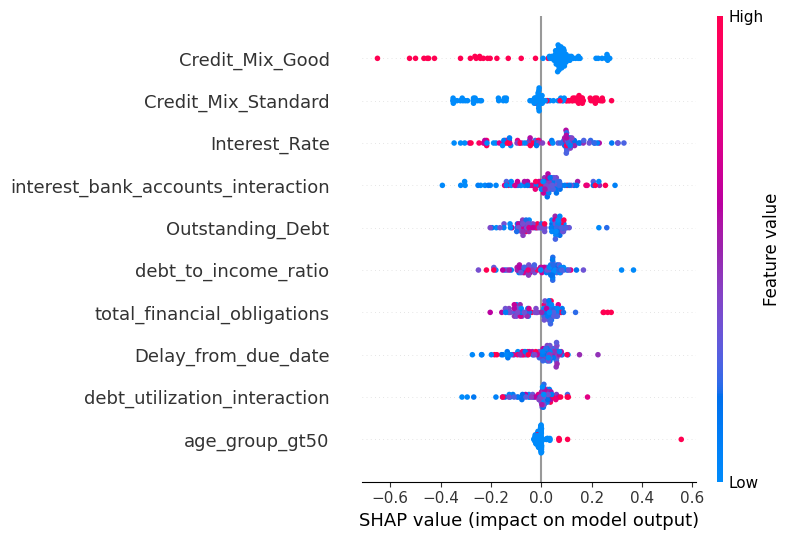

In [44]:
shap.summary_plot(shap_values, X)

In [45]:
X_test_scaled.columns

Index(['Interest_Rate', 'Delay_from_due_date', 'Outstanding_Debt',
       'debt_to_income_ratio', 'total_financial_obligations',
       'debt_utilization_interaction', 'interest_bank_accounts_interaction',
       'age_group_gt50', 'Credit_Mix_Good', 'Credit_Mix_Standard'],
      dtype='object')

The SHAP dependence plot for some of the features.

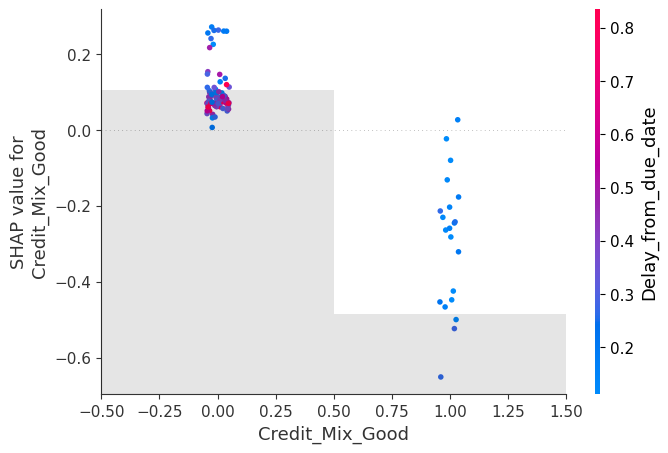

In [46]:
shap.plots.scatter(shap_values[:, "Credit_Mix_Good"], color=shap_values)

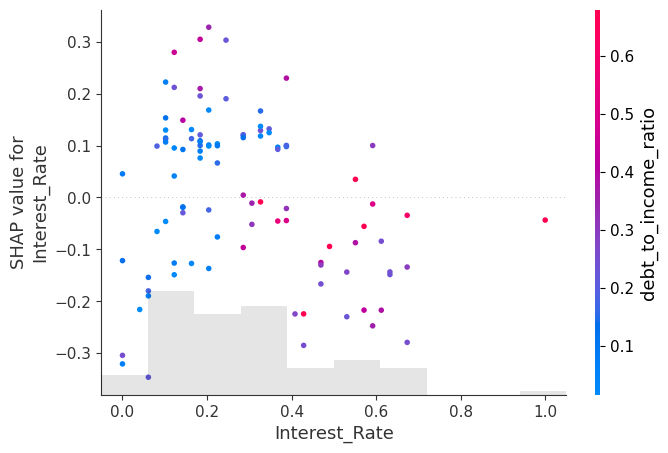

In [47]:
shap.plots.scatter(shap_values[:, "Interest_Rate"], color=shap_values)

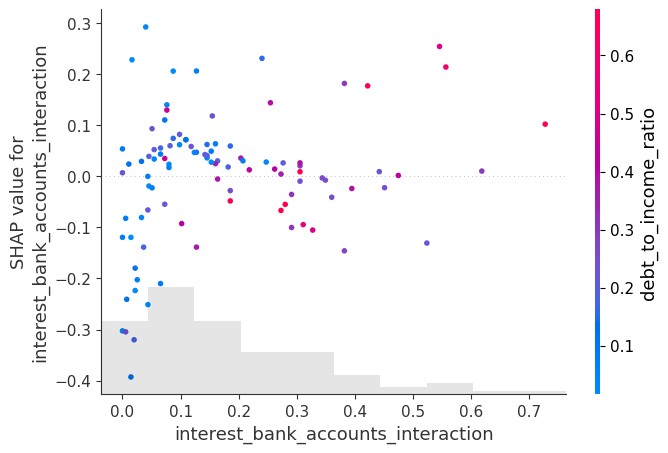

In [48]:
shap.plots.scatter(shap_values[:, "interest_bank_accounts_interaction"], color=shap_values)

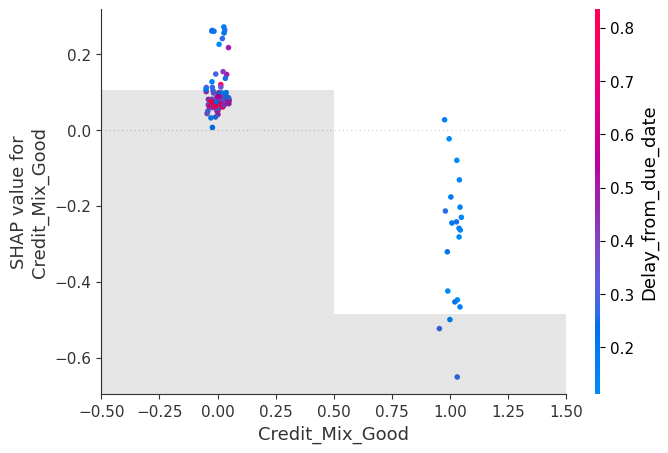

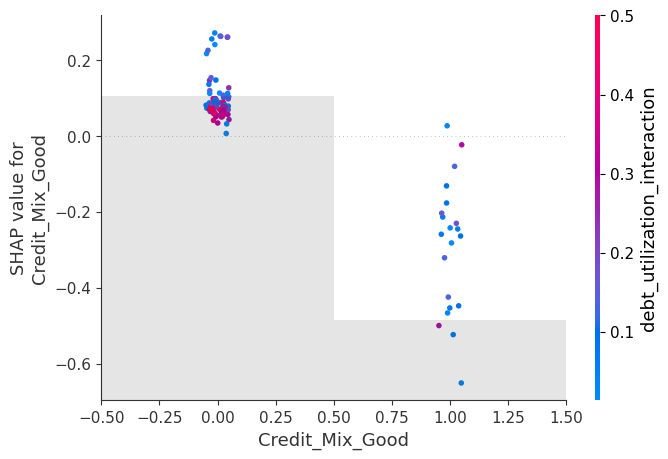

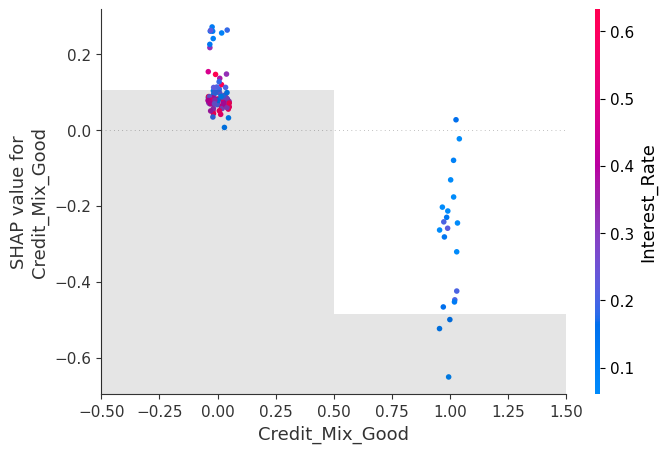

In [49]:
inds = shap.utils.potential_interactions(shap_values[:, "Credit_Mix_Good"], shap_values)

for i in range(3):
    shap.plots.scatter(shap_values[:, "Credit_Mix_Good"], color=shap_values[:, inds[i]])

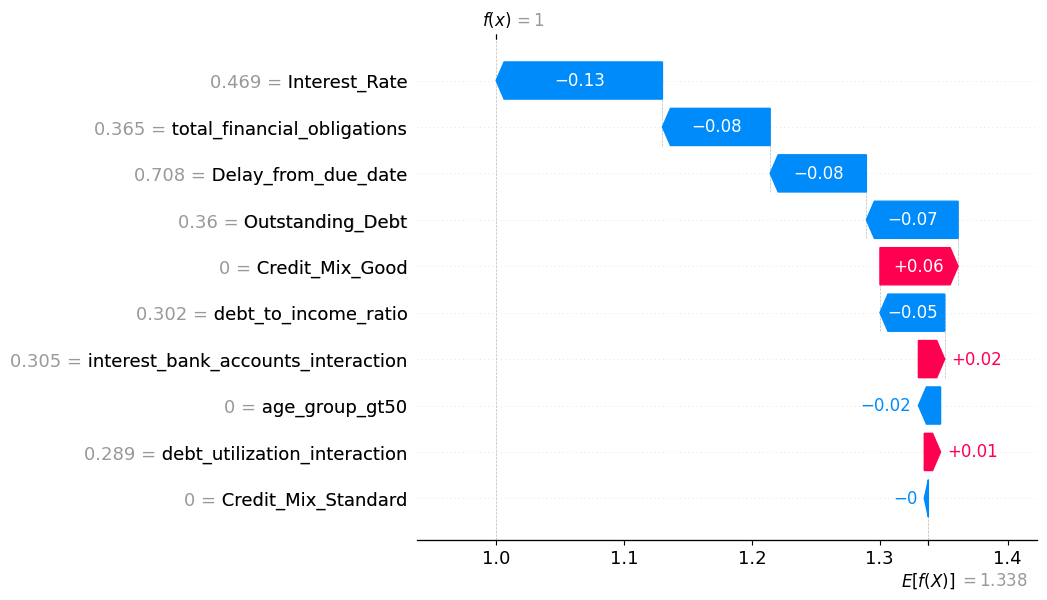

In [50]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[1])